In [17]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from scipy.cluster.vq import kmeans2
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


In [18]:
# Load your cleaned data
df = pd.read_csv('../data/cleaned_retail.csv', parse_dates=['InvoiceDate'])

# Set reference snapshot date (1 day after last purchase)
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)

# Calculate RFM features
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


In [19]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


In [20]:
from scipy.cluster.vq import kmeans2

# Use kmeans2 to avoid threadpool/OpenBLAS crash on macOS
k = 4  # Adjust based on elbow method
centroids, labels = kmeans2(rfm_scaled, k=k, iter=20, minit='++')

# Assign cluster labels
rfm['Cluster'] = labels


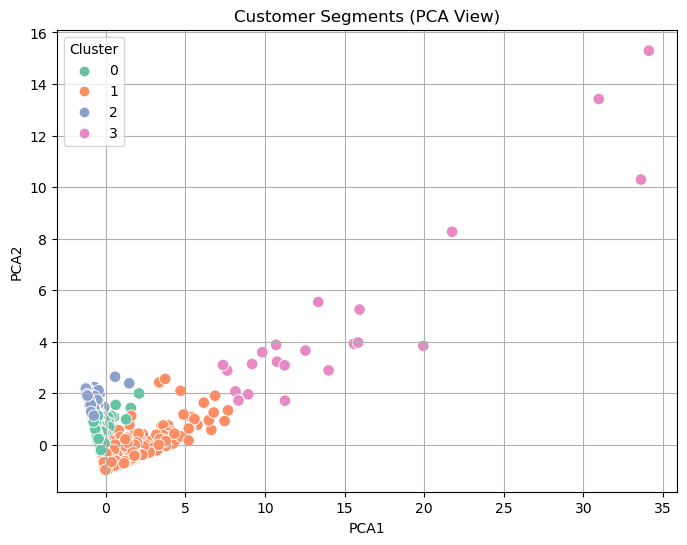

In [21]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(rfm_scaled)
rfm['PCA1'] = pca_result[:, 0]
rfm['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=rfm, palette='Set2', s=70)
plt.title('Customer Segments (PCA View)')
plt.grid(True)
plt.show()


In [22]:
rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'NumCustomers'}).round(2)


,Recency,Frequency,Monetary,NumCustomers
Cluster,,,,
0,333.25,2.68,899.20,1555
1,49.96,8.14,3437.72,3470
2,590.76,1.71,637.90,834
3,23.09,143.14,176557.66,22


In [23]:
segment_labels = {
    0: 'Loyal Customers',
    1: 'At Risk',
    2: 'Champions',
    3: 'Hibernating'
}

rfm['Segment'] = rfm['Cluster'].map(segment_labels)


In [24]:
rfm.to_csv('../data/customer_segments.csv', index=False)
